# Run GPSsplat on customized dataset

In [4]:
from __future__ import print_function, division

import argparse
import logging
import numpy as np
import cv2
import os
from pathlib import Path
from tqdm import tqdm

from lib.human_loader import StereoHumanDataset
from lib.network import RtStereoHumanModel
from config.stereo_human_config import ConfigStereoHuman as config
from lib.utils import get_novel_calib
from lib.GaussianRender import pts2render

import torch
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import json
import matplotlib.pyplot as plt


# 1. Understand the customized dataset

In [61]:
datapath = "real_data/Quentin_180_out_of_sync_black_full/test"
img_path = os.path.join(datapath, "img","0")
cam_path = os.path.join(datapath, "parm","0")

In [62]:
def load_cams_info(cam_path):

    cams_data = {}
    camfiles = os.listdir(cam_path)
    extrfiles = [f for f in camfiles if f.endswith('_extrinsic.npy')]
    intrfiles = [f for f in camfiles if f.endswith('_intrinsic.npy')]
    for extrfile, intrfile in zip(extrfiles, intrfiles):
        #load intrinsic and extrinsic camera parameters 
        camname = extrfile[:-14] + '.png'
        M = np.load(os.path.join(cam_path, extrfile))
        K = np.load(os.path.join(cam_path, intrfile))

        #read extrinsics
        
        cams_data[camname] = {'K': K, 'M': M}
    
    return cams_data

def load_images_from_folder(folder, cams_data, masked=False):
    images = []
    cams = []
    for filename in os.listdir(folder):
        #load image file
        if filename.endswith(".png") or filename.endswith(".jpg"):
            #search for the corresponding camera info
            #load image file
            if masked: #only load masked images
                if "masked" in filename:
                    img = cv2.cvtColor(cv2.imread(os.path.join(folder, filename)), cv2.COLOR_BGR2RGB)
                    images.append(img)
                    cams.append(cams_data[filename])
    return images, cams

In [63]:
cams_data = load_cams_info(cam_path)
images, cams = load_images_from_folder(img_path, cams_data=cams_data, masked=True)

In [64]:
cams_data

{'2025-04-14-16-03-48_5984D462-9E20-4746-95BB-0051C7EC13E1_masked_0.png': {'K': array([[1.4062227e+03, 0.0000000e+00, 9.6131085e+02],
         [0.0000000e+00, 1.4062227e+03, 9.7459064e+02],
         [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]], dtype=float32),
  'M': array([[ 9.6055657e-01,  5.8035855e-04, -2.7808413e-01, -1.2744830e+00],
         [ 1.4840525e-02,  9.9846584e-01,  5.3345837e-02,  1.1161486e+00],
         [ 2.7768847e-01, -5.5368610e-02,  9.5907426e-01,  1.0186104e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
        dtype=float32)},
 '2025-04-14-16-03-48_5F082D16-B555-4CA7-9975-9B0F1B1A946A_masked_0.png': {'K': array([[1.2707577e+03, 0.0000000e+00, 9.5603735e+02],
         [0.0000000e+00, 1.2707577e+03, 9.7026410e+02],
         [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]], dtype=float32),
  'M': array([[ 0.45141962, -0.05631894,  0.89053273,  1.0457897 ],
         [-0.01185875,  0.9975394 ,  0.06909756,  1.1411265 ],
         [-0

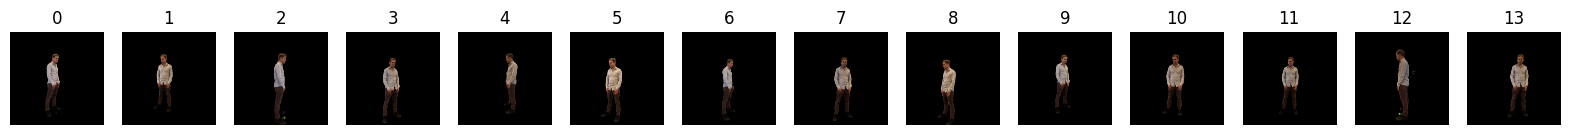

In [65]:
#show all images
length = len(images)
plt.figure(figsize=(20, 10))
for i in range(length):
    plt.subplot(1, length, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    #showing image id on top of the image
    plt.title(str(i))
plt.show()

In [69]:
#use mediapipe to detect the foreground mask of a human body, useed when no masks are provided
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic


def preprocess_image(images, masked=False, BG_COLOR=(127, 127, 127)):
    # Preprocess the images to get the foreground mask and resize to 1024x1024
    # This function is used when no masks are provided, and we use mediapipe to detect the foreground mask of a human body


    img_foregrounds = []
    masks = []

    for img in images:
        with mp_holistic.Holistic(
            static_image_mode=True,
            model_complexity=2,
            enable_segmentation=True,
            refine_face_landmarks=True) as holistic:
        
            # Convert the BGR image to RGB before processing.
            results = holistic.process(img)

        if masked: #if the image is already masked by iphone, use the iphone mask
            #find all pixels that are zero
            mask = np.ones_like(img[:, :, 0])
            mask[(img[:, :, 0] == 0) & (img[:,:,1]==0) & (img[:,:,2] ==0)] = 0
            img_foreground = np.uint8(img*mask[..., np.newaxis])
            img_foreground[mask< 0.2] = BG_COLOR
        else:   
            img_foreground = np.uint8(img*results.segmentation_mask[..., np.newaxis])
            img_foreground[results.segmentation_mask< 0.2] = BG_COLOR

        
        image_height, image_width, _ = img_foreground.shape

        #now work out the padding shape
        if image_height > image_width:
            pad = (image_height - image_width) // 2
            img_foreground = np.pad(img_foreground, ((0, 0), (pad, pad), (0, 0)), mode='constant', constant_values=BG_COLOR[0])

            #also pad the mask
            if not masked:
                mask = results.segmentation_mask.copy()
                mask[mask < 0.3] = 0
                mask[mask >= 0.3] = 1
            mask = np.pad(mask, ((0, 0), (pad, pad)), mode='constant', constant_values=0)


        elif image_width > image_height:
            pad = (image_width - image_height) // 2
            img_foreground = np.pad(img_foreground, ((pad, pad), (0, 0), (0, 0)), mode='constant', constant_values=BG_COLOR[0])
            #also pad the mask
            if not masked:
                mask = results.segmentation_mask.copy()
                mask[mask < 0.3] = 0
                mask[mask >= 0.3] = 1
            mask = np.pad(mask, ((pad, pad), (0, 0)), mode='constant', constant_values=0)
        else:
            pass

        #resize to 1024x1024
        """img_foreground = cv2.resize(img_foreground, (1920, 1920), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (1920, 1920), interpolation=cv2.INTER_LINEAR)"""

        #normalize to -1 to 1
        img_foreground = img_foreground / 127.5 - 1.0
        #convert to tensor
        #img_foreground = torch.from_numpy(img_foreground).permute(2, 0, 1).float().cuda()
        img_foregrounds.append(img_foreground)
        #mask = torch.from_numpy(mask).cuda()
        masks.append(mask)

    return img_foregrounds, masks


In [76]:
masked = True #True if images are all masked by iphone, False if images are not masked
BG_COLOR=(127, 127, 127)
img_foregrounds, masks = preprocess_image(images, masked=masked, BG_COLOR=BG_COLOR)

2025-05-15 15:08:39,189 WARNING  [image.py:720] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


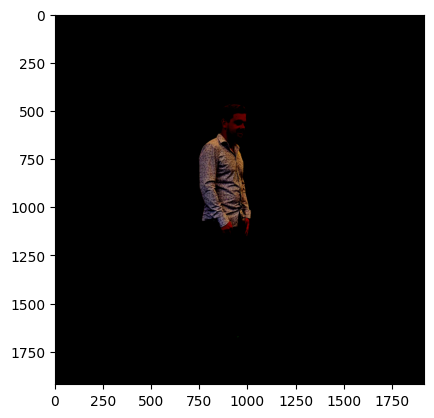

In [77]:
plt.imshow(img_foregrounds[0])

In [78]:
cams_data

{'2025-04-14-16-03-48_5984D462-9E20-4746-95BB-0051C7EC13E1_masked_0.png': {'K': array([[1.4062227e+03, 0.0000000e+00, 9.6131085e+02],
         [0.0000000e+00, 1.4062227e+03, 9.7459064e+02],
         [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]], dtype=float32),
  'M': array([[-9.6055657e-01,  5.8035855e-04,  2.7808413e-01, -1.2744830e+00],
         [-1.4840525e-02,  9.9846584e-01, -5.3345837e-02,  1.1161486e+00],
         [-2.7768847e-01, -5.5368610e-02, -9.5907426e-01,  1.0186104e+00],
         [-0.0000000e+00,  0.0000000e+00, -0.0000000e+00,  1.0000000e+00]],
        dtype=float32)},
 '2025-04-14-16-03-48_5F082D16-B555-4CA7-9975-9B0F1B1A946A_masked_0.png': {'K': array([[1.2707577e+03, 0.0000000e+00, 9.5603735e+02],
         [0.0000000e+00, 1.2707577e+03, 9.7026410e+02],
         [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]], dtype=float32),
  'M': array([[-0.45141962, -0.05631894, -0.89053273,  1.0457897 ],
         [ 0.01185875,  0.9975394 , -0.06909756,  1.1411265 ],
         [ 0

# 2. Rectification

Metashape parameters are opengl with camera frames rotated by 180 degrees around x, so will need to correct that and then transform to world to camera projection matrix ready for rectification

## 2.1 Utilities for rectification purposes

In [ ]:
import copy

def verify_camera_poses(cams_info: list):

    #Verifies the camera poses by visualizing them.
    def draw_local_axes(pos, va, vb):
        #draw small lines to represent the local axes of the camera
        plt.plot([pos[0], pos[0] + 0.3*va[0]], [pos[1], pos[1] + 0.3 * va[1]], c='r')
        plt.plot([pos[0], pos[0] + 0.3*vb[0]], [pos[1], pos[1] + 0.3 * vb[1]], c='b')
    #plot the camera positions in 3D space
    i=0
    for cam in cams_info:
        t = cam['M'][:3, 3].copy()
        va = cam['M'][::2, 2].copy()[::-1]
        vb = cam['M'][::2, 0].copy()[::-1]
        a,b = t[2], t[0]
        plt.plot(a, b, c='r', marker='*')
        plt.text(a, b, str(i), fontsize=12, color='black')
        draw_local_axes([a,b], va, vb)
        i+=1
    
    plt.axis('equal')
    plt.xlabel('Z-axis')
    plt.ylabel('X-axis')

def correct_camera_poses(cams_info: list):
    #make a copy of the camera poses
    cams_copy = copy.deepcopy(cams_info)
    #change the camera poses to facing inward
    for cam in cams_copy:
        #flip the x and z axis
        cam['M'][:,1] = -cam['M'][:,1]
        cam['M'][:,2] = -cam['M'][:,2]
    
    return cams_copy

#transform camera poses to world cam projection matrix
def world_to_camera(cams_info: list):
    #convert the camera poses world to camera matrix

    world_to_camera_matrices = []
    for cam in cams_info:
        #get the camera extrinsic matrix
        R = cam['M'][:3, :3]
        t = cam['M'][:3, 3]

        R_transposed = R.T
        t_new = -R_transposed @ t

        world_to_camera_matrix = np.eye(4)
        world_to_camera_matrix[:3, :3] = R_transposed
        world_to_camera_matrix[:3, 3] = t_new
        world_to_camera_matrices.append(world_to_camera_matrix)
    return world_to_camera_matrices

def extract_rt_from_extrinsic(E):
    """
    Extract the rotation matrix R and translation vector t from a 4x4 extrinsic matrix.
    """
    R = E[:3, :3]
    t = E[:3, 3]
    return R, t

def compute_relative_transform(E1, E2):
    """
    Given two extrinsic matrices (world-to-camera), compute the relative rotation and translation
    from camera 1 to camera 2.
    """
    R1, t1 = extract_rt_from_extrinsic(E1)
    R2, t2 = extract_rt_from_extrinsic(E2)
    R_rel = R2 @ R1.T         # Relative rotation: R2 * inv(R1)
    T_rel = t2 - R_rel @ t1   # Relative translation
    return R_rel, T_rel

    
def stereo_rectify(cams_info: list, world_cam_extrs: list, cam_ids):
    
    E1 = world_cam_extrs[cam_ids[0]]
    E2 = world_cam_extrs[cam_ids[1]]

    # Example intrinsic matrices (these would normally come from calibration).
    K1 = cams_info[cam_ids[0]]['K']
    K2 = cams_info[cam_ids[1]]['K']

    K1 = np.array(K1, dtype=np.float64)
    K2 = np.array(K2, dtype=np.float64)

    # Compute the relative transformation from camera 1 to camera 2.
    R_rel, T_rel = compute_relative_transform(E1, E2)
    R_rel = np.array(R_rel, dtype=np.float64)
    T_rel = np.array(T_rel, dtype=np.float64).reshape(3, 1)

    # Define the image size (width, height).
    width, height = 1028, 1920
    imageSize = (width, height)

    # Assume no lens distortion (distortion coefficients are zeros).
    distCoeffs1 = np.zeros((5, 1), dtype=np.float64)
    distCoeffs2 = np.zeros((5, 1), dtype=np.float64)

    newImageSize = (int(width * 1), int(height * 1))
    # Use OpenCV's stereoRectify to compute the rectification transforms.
    R1_rect, R2_rect, P1_rect, P2_rect, Q, roi1, roi2 = cv2.stereoRectify(
        cameraMatrix1=K1,
        distCoeffs1=distCoeffs1,
        cameraMatrix2=K2,
        distCoeffs2=distCoeffs2,
        imageSize=imageSize,
        R=R_rel,
        T=T_rel,
        flags=cv2.CALIB_ZERO_DISPARITY,
        alpha=0.8,  # alpha=0 will crop the images; adjust as needed.
        newImageSize=newImageSize  # None means the original image size will be used.
    )

    # Display results.
    print("Rectification rotation for camera 1 (R1_rect):\n", R1_rect)
    print("\nRectification rotation for camera 2 (R2_rect):\n", R2_rect)
    print("\nNew projection matrix for camera 1 (P1_rect):\n", P1_rect)
    print("\nNew projection matrix for camera 2 (P2_rect):\n", P2_rect)
    print("\nDisparity-to-depth mapping matrix (Q):\n", Q)

    return R1_rect, R2_rect, P1_rect, P2_rect, Q, roi1, roi2

def get_rectified_images(images, cams_info, world_cam_extrs, cam_ids):
    # Get the rectified images using the stereo_rectify function
    R1_rect, R2_rect, P1_rect, P2_rect, Q, roi1, roi2 = stereo_rectify(cams_info, world_cam_extrs, cam_ids)

    # Rectify the images
    img1 = images[cam_ids[0]]
    img2 = images[cam_ids[1]]

    # Get the intrinsic matrices
    K1 = cams_info[cam_ids[0]]['K']
    K2 = cams_info[cam_ids[1]]['K']

    # Rectify the images
    map1x, map1y = cv2.initUndistortRectifyMap(K1, np.zeros((5, 1)), R1_rect, P1_rect, (1920, 1920), cv2.CV_32FC1)
    map2x, map2y = cv2.initUndistortRectifyMap(K2, np.zeros((5, 1)), R2_rect, P2_rect, (1920, 1920), cv2.CV_32FC1)

    rectified_img1 = cv2.remap(img1.astype(np.float32), map1x, map1y, interpolation=cv2.INTER_LINEAR)
    rectified_img2 = cv2.remap(img2.astype(np.float32), map2x, map2y, interpolation=cv2.INTER_LINEAR)

    return rectified_img1.astype(np.uint8), rectified_img2.astype(np.uint8)

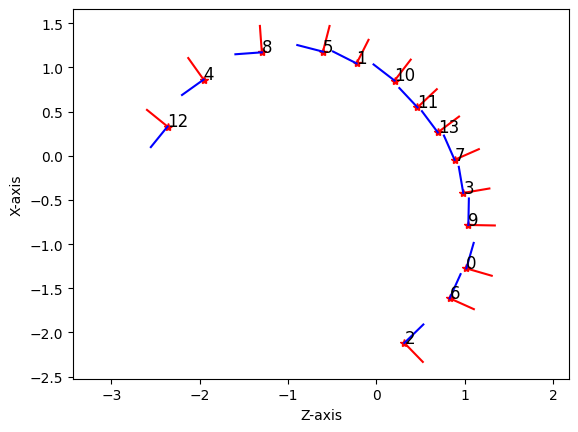

In [80]:
verify_camera_poses(correct_camera_poses(cams))

Rectification rotation for camera 1 (R1_rect):
 [[ 0.97895213 -0.04443668 -0.19919366]
 [ 0.04296541  0.99900799 -0.01170479]
 [ 0.19951618  0.00289999  0.97989024]]

Rectification rotation for camera 2 (R2_rect):
 [[ 0.98910614 -0.05203809  0.13769927]
 [ 0.05102305  0.99863806  0.01089336]
 [-0.1380786  -0.00374885  0.99041418]]

New projection matrix for camera 1 (P1_rect):
 [[2.46282219e+03 0.00000000e+00 5.61642353e+02 0.00000000e+00]
 [0.00000000e+00 2.46282219e+03 9.50562935e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]

New projection matrix for camera 2 (P2_rect):
 [[ 2.46282219e+03  0.00000000e+00  5.61642353e+02 -1.79514522e+03]
 [ 0.00000000e+00  2.46282219e+03  9.50562935e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]]

Disparity-to-depth mapping matrix (Q):
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -5.61642353e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -9.50562935e+02]
 [ 0

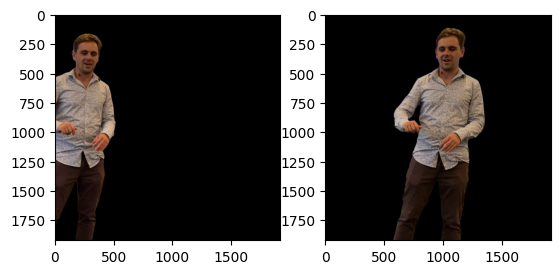

In [98]:
rec1, rect2 = get_rectified_images(images, cams, world_to_camera(cams), [7, 11])
plt.subplot(1, 2, 1)
plt.imshow(rec1)
plt.subplot(1, 2, 2)
plt.imshow(rect2)
plt.show()

In [88]:
import cv2
import matplotlib.pyplot as plt
import os
import json
import numpy as np

datapath = "D:/Data/human_body_data/Quentin_180_out_of_sync/2025-04-14-16-03-48"
img_path = os.path.join(datapath, "images_masked/64")
cam_path = os.path.join(datapath, "splatfacto/64")

In [89]:
def load_cams_info(cam_path):

    cams_data = {}
    with open(os.path.join(cam_path, "transforms.json")) as f:
        cams_info_raw = json.load(f)
    for cam in cams_info_raw['frames']:
        K = np.zeros((3, 3), dtype=np.float32)
        K[0,0] = cam['fl_x']
        K[1,1] = cam['fl_y']
        K[0,2] = cam['cx']
        K[1,2] = cam['cy']
        K[2,2] = 1.0

        #read extrinsics
        M = np.array(cam['transform_matrix']).astype(np.float32)
        cams_data[cam['file_path'].split('\\')[-1]] = {'K': K, 'M': M, 'img_shape': (cam['h'], cam['w'])}
    
    return cams_data

def load_images_from_folder(folder, cams_data, masked=False):
    images = []
    cams = []
    for filename in os.listdir(folder):
        #load image file
        if filename.endswith(".png") or filename.endswith(".jpg"):
            #search for the corresponding camera info
            #load image file
            if masked: #only load masked images
                if "masked" in filename:
                    img = cv2.cvtColor(cv2.imread(os.path.join(folder, filename)), cv2.COLOR_BGR2RGB)
                    images.append(img)
                    cams.append(cams_data[filename])
            else:
                img = cv2.cvtColor(cv2.imread(os.path.join(folder, filename)), cv2.COLOR_BGR2RGB)
                images.append(img)

                if filename not in cams_data.keys(): #if the image name is not in the camera data, add or remove "_masked" from the name
                    if "masked" in filename:
                        filename = filename.replace("_masked", "")
                    else:
                        namelist = filename.split('_')
                        namelist.insert(2, "masked")
                        filename = '_'.join(namelist)
                cams.append(cams_data[filename])               
    return images, cams

In [90]:
cams_data = load_cams_info(cam_path)
images, cams = load_images_from_folder(img_path, cams_data=cams_data, masked=False)

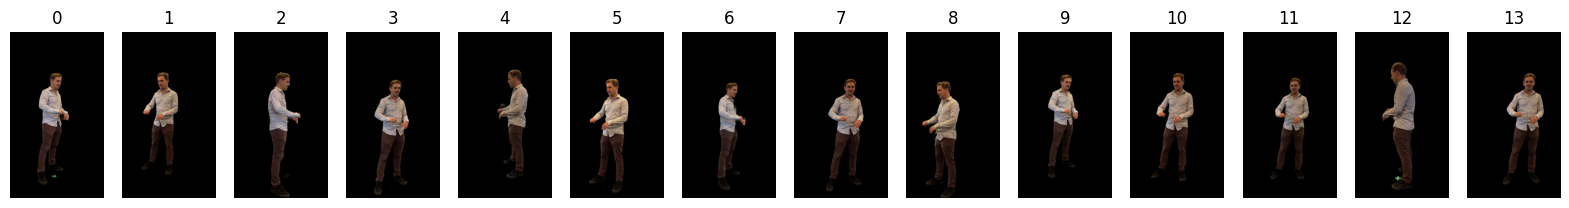

In [104]:
#show all images
length = len(images)
plt.figure(figsize=(20, 10))
for i in range(length):
    plt.subplot(1, length, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    #showing image id on top of the image
    plt.title(str(i))
plt.show()

In [92]:
import copy

#make a copy of the camera poses
cams_copy = copy.deepcopy(cams)
#change the camera poses to facing inward
for cam in cams_copy:
    #flip the x and z axis
    cam['M'][:,1] = -cam['M'][:,1]
    cam['M'][:,2] = -cam['M'][:,2]

In [93]:
world_to_camera_matrices = world_to_camera(cams_copy)

Rectification rotation for camera 1 (R1_rect):
 [[ 0.98973004  0.04857267  0.13444383]
 [-0.0464585   0.99874292 -0.01882004]
 [-0.13518896  0.0123807   0.99074248]]

Rectification rotation for camera 2 (R2_rect):
 [[ 0.99412694  0.05911113 -0.09065047]
 [-0.05768397  0.99816741  0.01828583]
 [ 0.09156525 -0.01294936  0.99571488]]

New projection matrix for camera 1 (P1_rect):
 [[1.27274640e+03 0.00000000e+00 5.06766117e+02 0.00000000e+00]
 [0.00000000e+00 1.27274640e+03 9.73571411e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]

New projection matrix for camera 2 (P2_rect):
 [[ 1.27274640e+03  0.00000000e+00  5.06766117e+02 -4.64216150e+02]
 [ 0.00000000e+00  1.27274640e+03  9.73571411e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]]

Disparity-to-depth mapping matrix (Q):
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -5.06766117e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -9.73571411e+02]
 [ 0

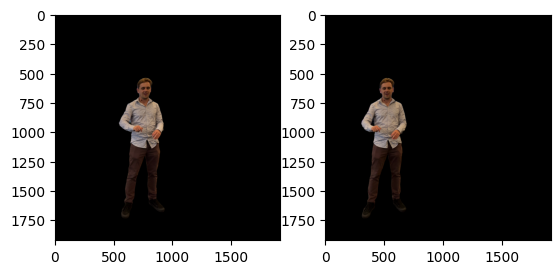

True

In [145]:
rect1, rect2 = get_rectified_images(images, cams_copy, world_to_camera_matrices, [7, 13])
plt.subplot(1, 2, 1)
plt.imshow(rect1)
plt.subplot(1, 2, 2)
plt.imshow(rect2)
plt.show()
cv2.imwrite('rectified_img1.jpg', cv2.cvtColor(rect1, cv2.COLOR_RGB2BGR))
cv2.imwrite('rectified_img2.jpg', cv2.cvtColor(rect2, cv2.COLOR_RGB2BGR))

In [146]:
rect1 = torch.from_numpy(rect1).permute(2, 0, 1).float().unsqueeze(0).cuda()
rect1 = rect1/127.5 - 1.0
rect2 = torch.from_numpy(rect2).permute(2, 0, 1).float().unsqueeze(0).cuda()
rect2 = rect2/127.5 - 1.0

In [147]:
class StereoHumanRender:
    def __init__(self, cfg_file, phase):
        self.cfg = cfg_file
        self.bs = self.cfg.batch_size

        self.model = RtStereoHumanModel(self.cfg, with_gs_render=True)
        self.dataset = StereoHumanDataset(self.cfg.dataset, phase=phase)
        self.model.cuda()
        if self.cfg.restore_ckpt:
            self.load_ckpt(self.cfg.restore_ckpt)
        self.model.eval()

    def infer_static(self, view_select, novel_view_nums):
        total_samples = len(os.listdir(os.path.join(self.cfg.dataset.test_data_root, 'img')))
        for idx in tqdm(range(total_samples)):
            item = self.dataset.get_test_item(idx, source_id=view_select)
            data = self.fetch_data(item)
            for i in range(novel_view_nums):
                ratio_tmp = (i+0.5)*(1/novel_view_nums)
                data_i = get_novel_calib(data, self.cfg.dataset, ratio=ratio_tmp, intr_key='intr_ori', extr_key='extr_ori')
                with torch.no_grad():
                    data_i, _, _ = self.model(data_i, is_train=False)
                    data_i = pts2render(data_i, bg_color=self.cfg.dataset.bg_color)

                render_novel = self.tensor2np(data['novel_view']['img_pred'])
                cv2.imwrite(self.cfg.test_out_path + '/%s_novel%s.jpg' % (data_i['name'], str(i).zfill(2)), render_novel)

    def tensor2np(self, img_tensor):
        img_np = img_tensor.permute(0, 2, 3, 1)[0].detach().cpu().numpy()
        img_np = img_np * 255
        img_np = img_np[:, :, ::-1].astype(np.uint8)
        return img_np

    def fetch_data(self, data):
        for view in ['lmain', 'rmain']:
            for item in data[view].keys():
                data[view][item] = data[view][item].cuda().unsqueeze(0)
        return data

    def load_ckpt(self, load_path):
        assert os.path.exists(load_path)
        logging.info(f"Loading checkpoint from {load_path} ...")
        ckpt = torch.load(load_path, map_location='cuda')
        self.model.load_state_dict(ckpt['network'], strict=True)
        logging.info(f"Parameter loading done")



In [148]:
import sys

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)-8s [%(filename)s:%(lineno)d] %(message)s')
sys.argv = ['script_name', '--test_data_root', 'real_data/Quentin_180_out_of_sync_black_full/test', '--ckpt_path', 'pretrained/GPS-GS_stage2_final.pth']

parser = argparse.ArgumentParser()
parser.add_argument('--test_data_root', type=str, required=True)
parser.add_argument('--ckpt_path', type=str, required=True)
parser.add_argument('--novel_view_nums', type=int, default=5)

arg = parser.parse_args()

cfg = config()
cfg_for_train = os.path.join('./config', 'stage2.yaml')
cfg.load(cfg_for_train)
cfg = cfg.get_cfg()   
cfg.defrost()
cfg.batch_size = 1
cfg.dataset.test_data_root = arg.test_data_root
cfg.dataset.use_processed_data = False
cfg.restore_ckpt = arg.ckpt_path
cfg.test_out_path = './interp_out'
Path(cfg.test_out_path).mkdir(exist_ok=True, parents=True)
cfg.freeze()

In [149]:
render = StereoHumanRender(cfg, phase='test')

2025-05-16 10:05:37,802 INFO     [1735310003.py:42] Loading checkpoint from pretrained/GPS-GS_stage2_final.pth ...
2025-05-16 10:05:38,055 INFO     [1735310003.py:45] Parameter loading done


In [150]:
from torch.cuda.amp import autocast as autocast

image = torch.cat([rect1, rect2], dim=0)


with autocast(enabled=render.model.cfg.raft.mixed_precision):
    img_feat = render.model.img_encoder(image)
flow_up = render.model.raft_stereo(img_feat[2], iters=render.model.val_iters, test_mode=True)

In [151]:
img_feat[2].shape

torch.Size([2, 96, 240, 240])

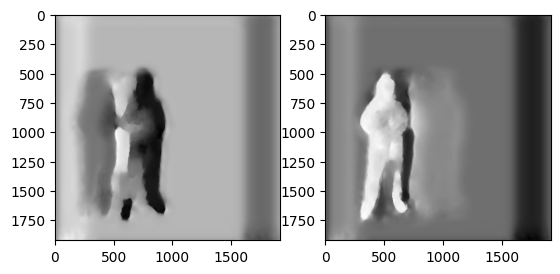

In [155]:
plt.subplot(1,2,1)
plt.imshow(flow_up[0][0].detach().cpu().numpy().squeeze(), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(flow_up[1][0].detach().cpu().numpy().squeeze(), cmap='gray')

### Conclusion: raftstereo doesn't work well maybe because it has not been trained on wider more diverse camera angles.